In [127]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import csv
from scipy.special import softmax
import pandas as pd

In [2]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [3]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded

In [10]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [8]:
train_dataset = PascalVOCSearchDataset('.',download = True, transform = augs)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [12]:
train_dataset[0][1].shape

torch.Size([21, 256, 256])

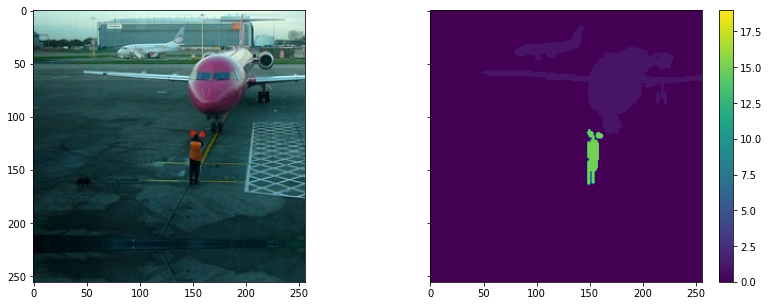

In [13]:
img,lbl = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(14,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

In [4]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [5]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

In [6]:
optim = torch.optim.AdamW(model.parameters(), lr = 2e-4, weight_decay = 1e-5)

In [10]:
dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 6)

In [7]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [8]:
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

In [20]:
r_losses = []
rloss = 0
next_desc = "first epoch"
for epoch in range(5):
  
  for img,lbl in tqdm(dataloader, desc = next_desc):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    loss = crit(predict, lbl)
    loss.backward()
    optim.step()
    optim.zero_grad()
    rloss += loss.detach().cpu().item() / len(dataloader)
  r_losses+= [rloss]
  next_desc = f"Epoch: [{epoch+1}], previous rloss: [{rloss:.3f}]"
  rloss = 0

Epoch: [4], previous rloss: [0.869]: 100%|████| 183/183 [01:38<00:00,  1.86it/s]


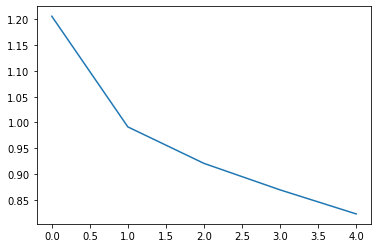

In [21]:
plt.plot(r_losses)

/tmp/ipykernel_3175/568789041.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


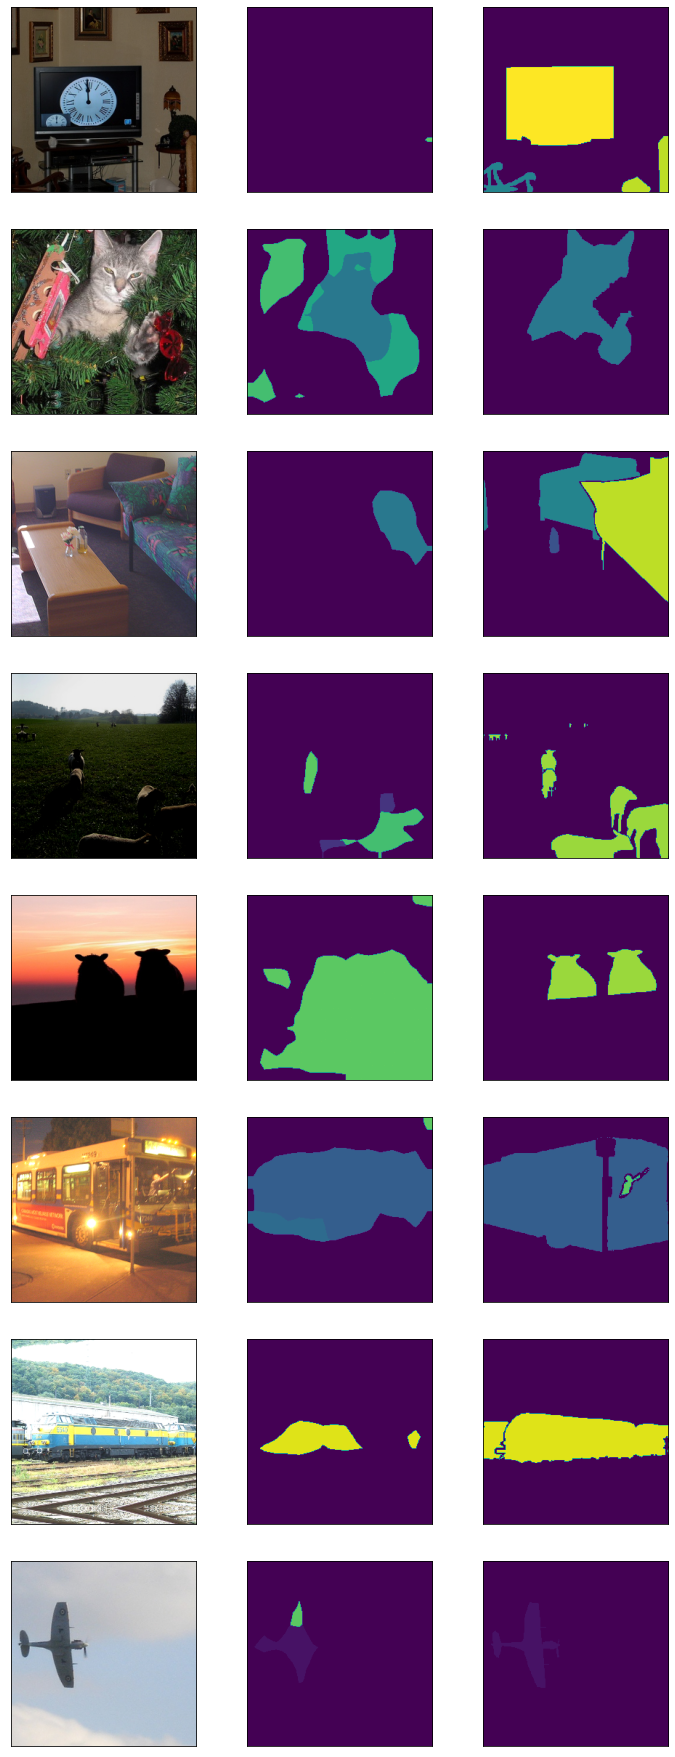

In [22]:
fig,axes = plt.subplots(len(lbl), 3, figsize = (12, len(lbl) * 4))
for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predict.detach().cpu().softmax(1), lbl.detach().cpu())):
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()

#### Задание 
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам.
(пользоваться уже написанным IoU)
5. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в csv табличку: номер пуска: MIoU в среднем по классам)
4. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
5. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
6. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.
* Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив).
** При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять. 





In [11]:
#для валидации нужно разделить датасет на обучающую и тестовую(валидирующую) выборку
#внутри датасета три типа выборки: train, trainval, val. Непонятно что лежит в trainval
#(возможно микс из train и val) Поэтому наверняка возьмем val

#Логично для валидации оставить данные как они есть без изменения цветов и только привести к нужному размеру
size_fix = Compose([
                 PadIfNeeded(448,448),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

train_dataset = PascalVOCSearchDataset('.', image_set = "train",download = True, transform = augs)
test_dataset = PascalVOCSearchDataset('.', image_set = "val",download = True, transform = size_fix)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [12]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 4)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = True, num_workers = 4)

In [15]:
r_losses = []
val_accuracy = []
train_accuracy = []
rloss = 0
val_desc = "val"
next_desc = "train"

for epoch in range(5):
    #обучение
    model.train()
    for img,lbl in tqdm(train_dataloader, desc = next_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()
        rloss += loss.detach().cpu().item() / len(train_dataloader)
    r_losses+= [rloss]
    next_desc = f"train Epoch: [{epoch+1}], loss: [{rloss:.3f}], accuracy: {1-rloss:.3f}"
    train_accuracy.append(1-rloss)
    rloss = 0
    #валидация
    model.eval()
    for img,lbl in tqdm(test_dataloader, desc = val_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        rloss += loss.detach().cpu().item() / len(test_dataloader)
    val_desc = f"val Epoch: [{epoch+1}], loss: [{rloss:.3f}], accuracy: {1-rloss:.3f}"
    val_accuracy.append(1-rloss)
    rloss = 0

val: 100%|████████████████████████████████████| 182/182 [01:37<00:00,  1.87it/s]
train Epoch: [1], loss: [0.499], accuracy: 0.501: 100%|█| 183/183 [01:39<00:00, 
val Epoch: [1], loss: [0.433], accuracy: 0.567: 100%|█| 182/182 [01:36<00:00,  1
train Epoch: [2], loss: [0.385], accuracy: 0.615: 100%|█| 183/183 [01:39<00:00, 
val Epoch: [2], loss: [0.328], accuracy: 0.672: 100%|█| 182/182 [01:38<00:00,  1
train Epoch: [3], loss: [0.340], accuracy: 0.660: 100%|█| 183/183 [01:39<00:00, 
val Epoch: [3], loss: [0.350], accuracy: 0.650: 100%|█| 182/182 [01:36<00:00,  1
train Epoch: [4], loss: [0.340], accuracy: 0.660: 100%|█| 183/183 [01:39<00:00, 
val Epoch: [4], loss: [0.336], accuracy: 0.664: 100%|█| 182/182 [01:37<00:00,  1


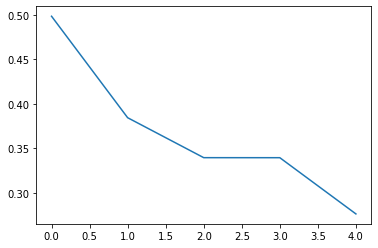

In [16]:
plt.plot(r_losses)

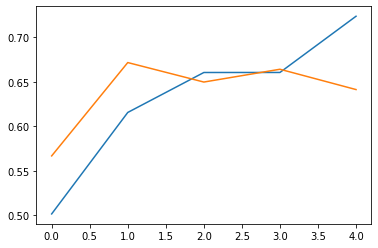

In [17]:
plt.plot(train_accuracy) #синий
plt.plot(val_accuracy) #оранжевый

In [13]:
#IoU (Interseption over union) - метрика
#для каждого класса это (true positive / true positive + false positive + false negative)

def compute_iou(predict, lbl):
    a = []
    for p, l in zip(predict, lbl):
        s = []
        for k in range(len(lbl[0])):
            result1 = p[0][k]
            result2 = l[0][k]
            intersection = np.logical_and(result1, result2)
            union = np.logical_or(result1, result2)
            iou = np.sum(intersection) / np.sum((union + 1e-8))
            s.append(iou)
        a.append(s)
    a = np.array(a)
    return a

def compute_mean_iou(predict, lbl):
    iou_score = compute_iou(predict, lbl)
    iou_score = np.mean(iou_score)
    return iou_score

In [130]:
#пример вычисления IoU на одном батче
for img,lbl in test_dataloader:
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    predict = predict.cpu().detach().numpy()
    #print('predict: ', predict)
    lbl = lbl.cpu().detach().numpy()
    iou = compute_iou(predict, lbl)
    print('IoU shape is', iou.shape)
    print('meanIoU', compute_mean_iou(predict, lbl))
    break

IoU shape is (8, 21)
meanIoU 0.8761625656431361


In [131]:
#IoU в среднем на датасете на последней валидации

avg_iou = np.zeros_like(iou)

for img,lbl in test_dataloader:
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    predict = predict.cpu().detach().numpy()
    lbl = lbl.cpu().detach().numpy()
    avg_iou += compute_iou(predict, lbl)
        
avg_iou = avg_iou / len(test_dataloader)

In [66]:
print(avg_iou)

[[0.82544213 0.82471239 0.82449776 0.82385387 0.82396119 0.82898351
  0.82887619 0.82866156 0.82780305 0.82861864 0.82816792 0.82941277
  0.82870449 0.82915521 0.82840401 0.8265582  0.82520604 0.82391826
  0.82248025 0.82026957 0.81840229]
 [0.80412946 0.80550308 0.80535284 0.80372166 0.80071685 0.79990126
  0.79915006 0.79833447 0.79674621 0.79603794 0.79395604 0.79213169
  0.79168097 0.78929858 0.78661572 0.78373969 0.78215143 0.78133584
  0.77942564 0.77672132 0.77451064]
 [0.77277214 0.77240727 0.77221411 0.77176339 0.77167753 0.77045415
  0.76800738 0.76702008 0.76983172 0.76472355 0.76392942 0.76362894
  0.76311383 0.7615685  0.76096754 0.75991586 0.75862808 0.75776957
  0.75663203 0.75527987 0.75328382]
 [0.83827695 0.83774038 0.83598042 0.83125858 0.82990641 0.82911229
  0.8290479  0.82930545 0.82984202 0.82868303 0.82833962 0.8282967
  0.82776012 0.82711623 0.82720209 0.82763134 0.82763134 0.82831816
  0.82803914 0.82724501 0.82705185]
 [0.81694281 0.81655648 0.81730768 0.8172

In [125]:
#подготовка csv файла для записи
line = ['0', 'best_val']
with open('launches.csv', 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(line)

In [14]:
def log_in_csv(val):
    with open('launches.csv', 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            n = row[0]
    nn = int(n) + 1
    line = [nn, val]
    with open('launches.csv', 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(line)

In [15]:
#обучение с логированием лучшей валидации

r_losses = []
val_accuracy = []
train_accuracy = []
val_miou = 0
all_val_miou = []
best_val_miou = 0
rloss = 0
val_desc = "val"
next_desc = "train"

for epoch in range(5):
    #обучение
    model.train()
    for img,lbl in tqdm(train_dataloader, desc = next_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()
        rloss += loss.detach().cpu().item() / len(train_dataloader)
    r_losses+= [rloss]
    next_desc = f"train Epoch: [{epoch+1}], loss: [{rloss:.3f}]"
    train_accuracy.append(1-rloss)
    rloss = 0
    #валидация
    model.eval()
    for img,lbl in tqdm(test_dataloader, desc = val_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        rloss += loss.detach().cpu().item() / len(test_dataloader)
        predict = predict.cpu().detach().numpy()
        lbl = lbl.cpu().detach().numpy()
        t = compute_mean_iou(predict, lbl)
        if (best_val_miou < t):
            best_val_miou = t
        val_miou += t
        all_val_miou.append(t)
    val_miou = val_miou / len(test_dataloader)
    val_desc = f"val Epoch: [{epoch+1}], loss: [{rloss:.3f}], MIoU: {val_miou}"
    val_accuracy.append(1-rloss)
    rloss = 0
log_in_csv(val_miou)
print("best val miou:", best_val_miou)

train Epoch: [1], loss: [0.459]: 100%|████████| 183/183 [01:39<00:00,  1.84it/s]
val Epoch: [1], loss: [0.367], MIoU: 0.8199073793352667: 100%|█| 182/182 [01:40<
train Epoch: [2], loss: [0.389]: 100%|████████| 183/183 [01:38<00:00,  1.86it/s]
val Epoch: [2], loss: [0.346], MIoU: 0.825863666596013: 100%|█| 182/182 [01:42<0
train Epoch: [3], loss: [0.340]: 100%|████████| 183/183 [01:38<00:00,  1.86it/s]
val Epoch: [3], loss: [0.353], MIoU: 0.8267726679284915: 100%|█| 182/182 [01:41<
train Epoch: [4], loss: [0.339]: 100%|████████| 183/183 [01:38<00:00,  1.86it/s]
val Epoch: [4], loss: [0.373], MIoU: 0.8318045830150578: 100%|█| 182/182 [01:41<

best val miou: 0.9999999899999997


In [16]:
all_val_miou = torch.tensor(all_val_miou)

In [83]:
#отображение картинок по квантилям

def plot_images(indx):
    img, lbl = test_dataset[indx]
    
    img = img.reshape(1, 3, 256, 256)
    img = img.cuda()
    pred = model(img)['out']
    pred = pred.detach().cpu()[0]
    
    fig,axes = plt.subplots(1, 3, figsize = (12, 1 * 4))
    axes[0].imshow(img.reshape(3, 256, 256).detach().cpu().permute(1,2,0))
    axes[1].imshow(pred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
    axes[2].imshow(lbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)

def quantile(ql, qr):
    mask = torch.logical_and((all_val_miou.quantile(ql) <= all_val_miou), (all_val_miou < all_val_miou.quantile(qr))) 
    ii = mask.nonzero()[:2]

    for indx in ii:
        plot_images(indx)

< 10%


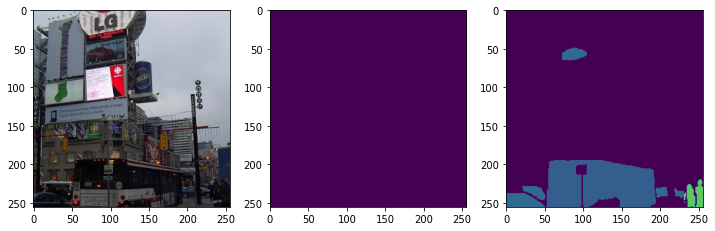

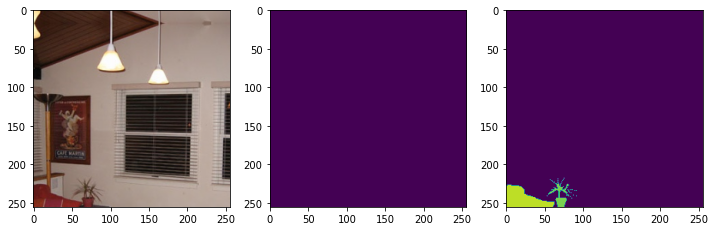

In [86]:
print('< 10%')
quantile(0, 0.1)

[15%,25%]


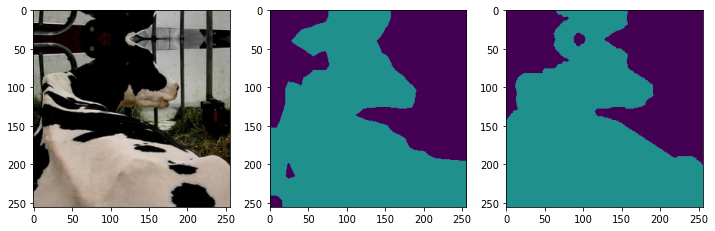

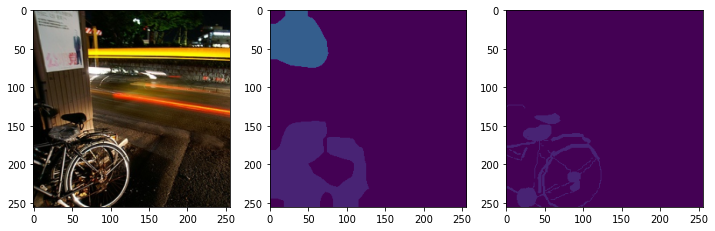

In [88]:
print('[15%,25%]')
quantile(0.15, 0.25)

[35%,45%]


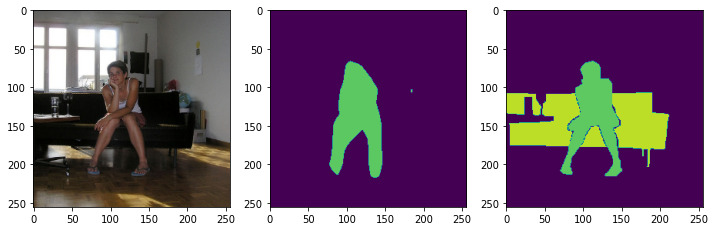

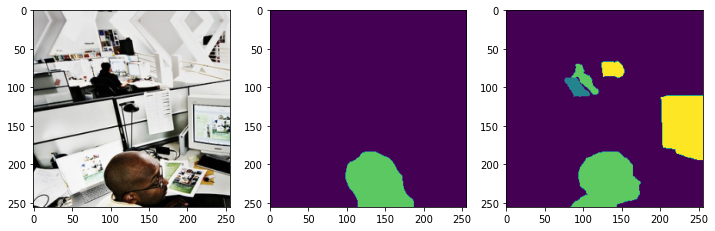

In [89]:
print('[35%,45%]')
quantile(0.35, 0.45)

In [110]:
#лучшие картинки (в трех классах)

torch.max(all_val_miou, dim = 0)

torch.return_types.max(
values=tensor(1.0000, dtype=torch.float64),
indices=tensor(138))

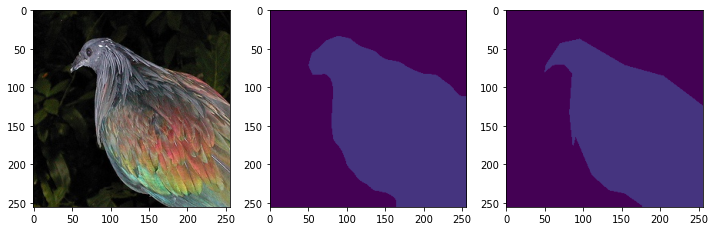

In [109]:
plot_images(138) #лучший результат

In [121]:
torch.where(all_val_miou > 0.9999999)

(tensor([138, 181, 220, 288, 363, 451, 537, 545, 551, 560, 572, 697, 727, 800]),)

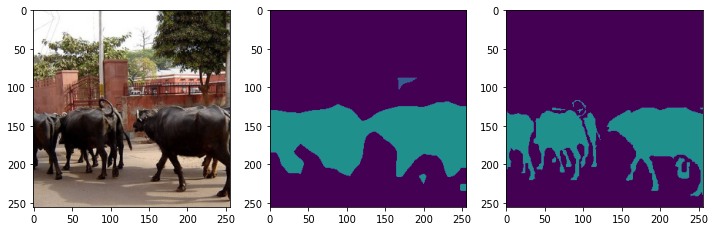

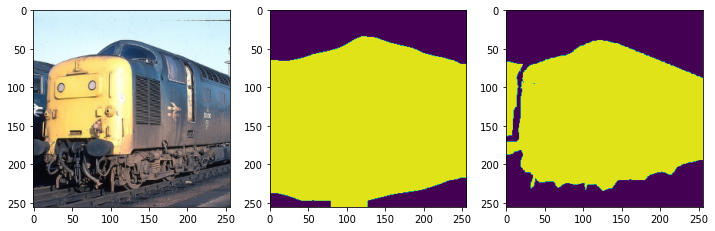

In [125]:
plot_images(220)
plot_images(181)

In [146]:
#посчитать таблицу IoU в развертке по каждому классу

ios = []
model.eval()
for img,lbl in test_dataloader:
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    predict = predict.cpu().detach().numpy()
    lbl = lbl.cpu().detach().numpy()
    ios += [compute_iou(predict, lbl)]

In [150]:
a = np.array(ios, dtype=object)

In [158]:
a[0].shape, len(a)

((8, 21), 182)

In [159]:
b = []
for i in a:
    b.extend(i)
len(b)

1449

In [160]:
pd.DataFrame(b, columns=VOC_CLASSES)

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,diningtable,dog,horse,motorbike,person,potted plant,sheep,sofa,train,tv/monitor
0,0.953125,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.0,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.0,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.0,1.000000
3,0.519531,0.519531,0.523437,0.523437,0.523437,0.523437,0.527344,0.527344,0.531250,0.531250,...,0.535156,0.539062,0.484375,0.414062,0.347656,0.109375,0.000,0.000000,0.0,0.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.0,0.960937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.0,1.000000
1445,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.0,1.000000
1446,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.0,1.000000
1447,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.0,1.000000
